In [1]:
# Libraries
import numpy as np
from struct import unpack # バイト値から変換
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap # 地図データの使用
from matplotlib import pyplot as plt # 描画用
from matplotlib.colors import ListedColormap # カラーバーの色について

In [2]:
# read
f = open('./original/2015/03/03/Z__C_RJTD_20150303000000_SRF_GPV_Ggis1km_Prr60lv_ANAL_grib2.bin', 'rb').read()
sec_0 = f[:16] # 第0節　16オクテット
sec_1 = f[16:37] # 第1節　21オクテット
sec_2 = f[0] # 第2節　不使用
sec_3 = f[37:109] # 第3節　72オクテット
sec_4 = f[109:191] # 第4節　82オクテット
sec_5 = f[191:404] # 第5節　213オクテット
sec_6 = f[404:410] # 第6節　6オクテット
sec_7 = f[410:-4] # 第7節　資料節
sec_8 = f[-4:] # 第8節　4オクテット

In [3]:
# 時刻の入手（1つだけ取り出すと勝手にintになる）
Y = sec_1[12] * 256 + sec_1[13]
M = sec_1[14]
D = sec_1[15]
H = sec_1[16]
JST = datetime(Y, M, D, H) + timedelta(hours=9)
print(JST)
Y, M, D, H = JST.year, JST.month, JST.day, JST.hour

2015-03-03 09:00:00


In [4]:
# ランレングス圧縮の中身
length = sec_7[0] * 2 ** 24 + sec_7[1] * 2 ** 16 + sec_7[2] * 2 ** 8 + sec_7[3] # 第7節の長さ
run_len = unpack('{}B'.format(length - 5), sec_7[5:]) # 7節ランレングスデータをバイナリから1バイト整数に変換する
NBIT = sec_5[11] # 1格子あたりのビット数
MAXV = sec_5[12] * 256 + sec_5[13] # レベルの最大値
LNGU = 2 ** NBIT - MAXV - 1 # ランレングスで使用する進数

data = []
for i in run_len:
    if i <= MAXV:
        lev = i
        power = 0
        data.append(i)
    else:
        n_len = (i - (MAXV + 1)) * LNGU ** power # レベル値を繰り返す個数
        data += [lev] * n_len # レベル値をさらにn_len個繰り返す
        power += 1

# 2次元データに変換
data = np.array(data, dtype='f4')
data = data.reshape((3360, 2560))

# レベル値0は欠損値
data[data == 0] = -1

In [5]:
# level to rep
rep_list = unpack('>98H', sec_5[17:])
for i in list(range(1, 99))[::-1]:
    data[data == i] = rep_list[i-1]
data[data == -1] = np.nan # 先程の欠損値処理
data = data * 1.0e-01 # 格納されている代表値は実際の代表値の10倍

In [6]:
# 地図情報など
fonts = {'family':'Times New Roman', 'size':20}
x = np.linspace(118. + 1. / 160., 150. - 1. / 160., 2560)
y = np.linspace(48. - 1. / 240., 20. + 1. / 240., 3360)
lon, lat = np.meshgrid(x, y)
mp = Basemap(projection='cyl', llcrnrlon=118., urcrnrlon=150., llcrnrlat=20., urcrnrlat=48., resolution='l')
cmap = ListedColormap(['orange', 'grey', 'blue', 'skyblue', 'lightgrey'])
colors = ["skyblue", "dodgerblue", "blue", "yellow", "orange", "red", "purple"]

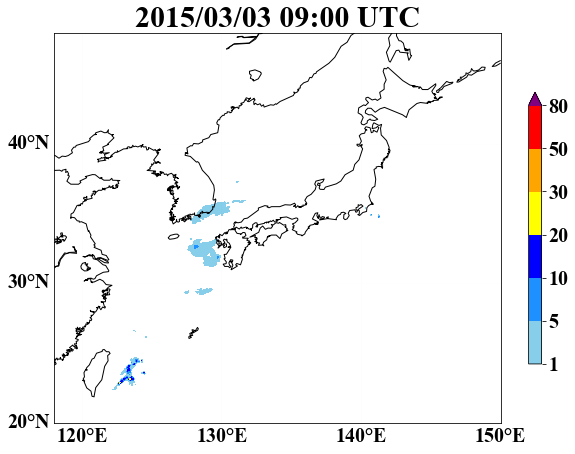

In [7]:
%matplotlib inline
plt.rc('font', **fonts)
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
mp.drawcoastlines(ax=ax)
mp.drawmeridians(np.arange(0., 361., 10.), labels=[True, False, False, True], linewidth=0.01, ax=ax)
mp.drawparallels(np.arange(-90., 91., 10.), labels=[True, False, False, True], linewidth=0.01, ax=ax) 
plot = ax.contourf(lon, lat, data, [1, 5, 10, 20, 30, 50, 80], colors=colors, extend="max")
cbar = fig.colorbar(plot, shrink=0.5)
ax.set_title('{0:04d}/{1:02d}/{2:02d} {3:02d}:00'.format(Y, M, D, H), fontsize=30)

plt.show()
plt.close('all')